<a href="https://colab.research.google.com/github/Anggunnurfitriani/Data-Mining/blob/master/FP_TS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Basic packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rd # generating random numbers
import datetime # manipulating date formats
# Viz
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots


# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Import all of them 
sales=pd.read_csv("sales_train.csv")

In [3]:
#formatting the date column correctly
sales.date=sales.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))
# check
print(sales.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
None


In [4]:
# Aggregate to monthly level the required metrics

monthly_sales=sales.groupby(["date_block_num","shop_id","item_id"])[
    "date","item_price","item_cnt_day"].agg({"date":["min",'max'],"item_price":"mean","item_cnt_day":"sum"})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


In [5]:
# take a peak
monthly_sales.tail(20)

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
33             59      20730   2015-10-31 2015-10-31      499.0          1.0
                       20751   2015-10-10 2015-10-10      699.0          1.0
                       20866   2015-10-01 2015-10-31      699.0          4.0
                       20949   2015-10-02 2015-10-31        5.0         19.0
                       21361   2015-10-08 2015-10-08     1999.0          1.0
                       21364   2015-10-24 2015-10-24      399.0          1.0
                       21369   2015-10-10 2015-10-31      169.0          2.0
                       21377   2015-10-24 2015-10-24      169.0          1.0
                       21386   2015-10-08 2015-10-08      169.0          1.0
                       21404   2015-10-10 2015-10-16      169.0          1.0
                       21427   2015-10-04 2015-10-04      169.0          1.0
                       21449   2015-10-30 2015-10-31      449.0          2.0
                       21672   2015-10-14 2015-10-14      249.0          1.0
                       21811   2015-10-27 2015-10-27      199.0          1.0
                       21812   2015-10-17 2015-10-17       99.0          1.0
                       22087   2015-10-05 2015-10-23      119.0          6.0
                       22088   2015-10-03 2015-10-27      119.0          2.0
                       22091   2015-10-03 2015-10-03      179.0          1.0
                       22100   2015-10-18 2015-10-18      629.0          1.0
                       22102   2015-10-16 2015-10-16     1250.0          1.0

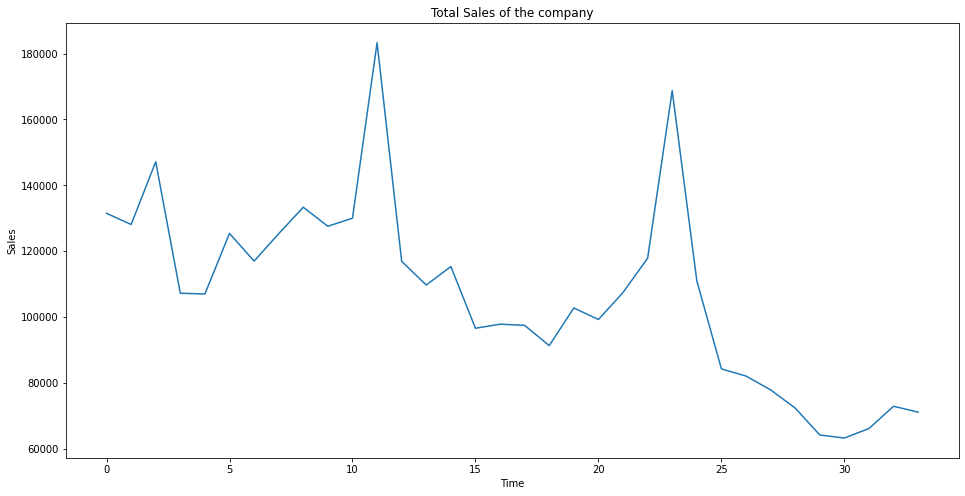

In [6]:
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts);

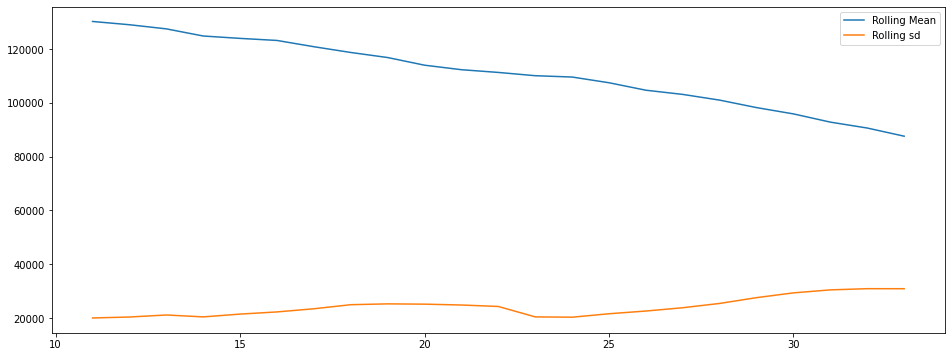

In [7]:
plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend();

In [8]:
# adding the dates to the Time-series as index
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.index=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')
ts=ts.reset_index()
ts.head()

,index,item_cnt_day
0,2013-01-01,131479.0
1,2013-02-01,128090.0
2,2013-03-01,147142.0
3,2013-04-01,107190.0
4,2013-05-01,106970.0


In [9]:
ts_train=ts[0:31]
ts_test=ts[31:]
ts_test

,index,item_cnt_day
31,2015-08-01,66079.0
32,2015-09-01,72843.0
33,2015-10-01,71056.0


In [21]:
#ts.to_csv(r"data for arima in r.csv")

In [22]:
#ts_train.to_csv(r"train for arima in r.csv")

In [10]:
# Stationarity tests
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(ts_train.item_cnt_day)

Results of Dickey-Fuller Test:
Test Statistic                 -2.412002
p-value                         0.138377
#Lags Used                      0.000000
Number of Observations Used    30.000000
Critical Value (1%)            -3.669920
Critical Value (5%)            -2.964071
Critical Value (10%)           -2.621171
dtype: float64


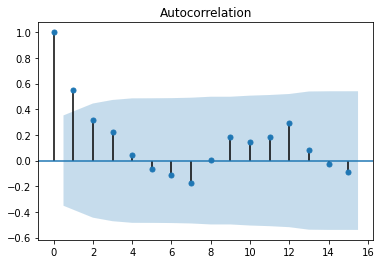

In [29]:
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(ts_train.item_cnt_day)
pyplot.show()

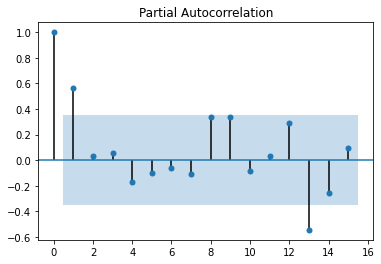

In [33]:
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(ts_train.item_cnt_day)
pyplot.show()

In [11]:
# to remove trend
from pandas import Series as Series
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob

[]

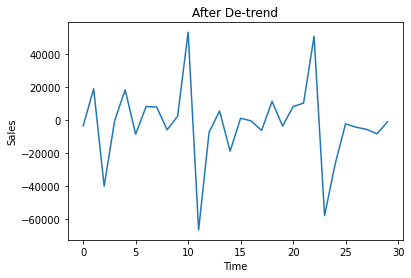

In [12]:
plt.title('After De-trend')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts_train.item_cnt_day)
plt.plot(new_ts)
plt.plot()


[]

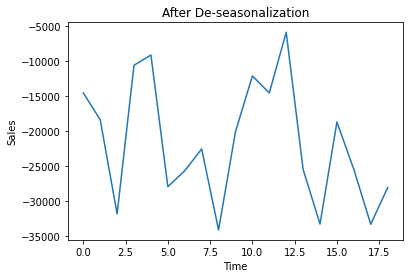

In [13]:
plt.title('After De-seasonalization')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts_train.item_cnt_day,12)       # assuming the seasonality is 12 months long
plt.plot(new_ts)
plt.plot()

In [14]:
# now testing the stationarity again after de-seasonality
test_stationarity(new_ts)

Results of Dickey-Fuller Test:
Test Statistic                 -1.359865
p-value                         0.601359
#Lags Used                      7.000000
Number of Observations Used    11.000000
Critical Value (1%)            -4.223238
Critical Value (5%)            -3.189369
Critical Value (10%)           -2.729839
dtype: float64


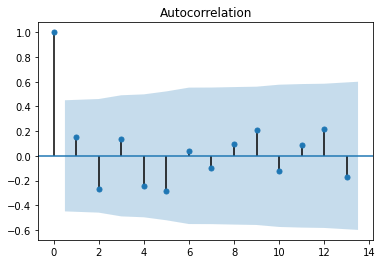

In [35]:
plot_acf(new_ts)
pyplot.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  Default is None.


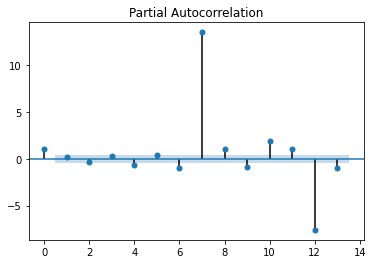

In [37]:
plot_pacf(new_ts)
pyplot.show()

In [23]:
#new_ts.to_csv(r"data for arima")

In [24]:
#ts.to_csv(r"data for arima in r")

In [15]:
#! pip install pmdarima

     |████████████████████████████████| 1.5MB 8.9MB/s 
     |████████████████████████████████| 9.5MB 39.2MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [16]:
from pmdarima.arima import auto_arima

In [17]:
ts_train.head()

,index,item_cnt_day
0,2013-01-01,131479.0
1,2013-02-01,128090.0
2,2013-03-01,147142.0
3,2013-04-01,107190.0
4,2013-05-01,106970.0


In [38]:
arima_model=auto_arima(ts_train.item_cnt_day, start_p=0, max_p=5, d=1, start_q=0, max_q=5,start_P=0, max_P=5,D=1, start_Q=0, max_Q=5, m=12, seasonal=True, trace=True, error_action='ignore')

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=388.953, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=391.464, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=nan sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=393.492, Time=0.10 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=nan sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=nan sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=390.893, Time=0.03 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=391.012, Time=0.03 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=392.684, Time=0.12 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=390.811, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 0.425 seconds


In [24]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   31
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -193.476
Date:                            Mon, 21 Jun 2021   AIC                            388.953
Time:                                    17:37:15   BIC                            389.843
Sample:                                         0   HQIC                           389.075
                                             - 31                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.166e+08   4.66e+07      2.502      0.012    2.53e+07    2.08e+08
===================================================================================
Ljung-Box (Q):                         nan   Jarque-Bera (JB):                 0.51
Prob(Q):                               nan   Prob(JB):                         0.77
Heteroskedasticity (H):               0.79   Skew:                             0.10
Prob(H) (two-sided):                  0.78   Kurtosis:                         2.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh',title=''):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

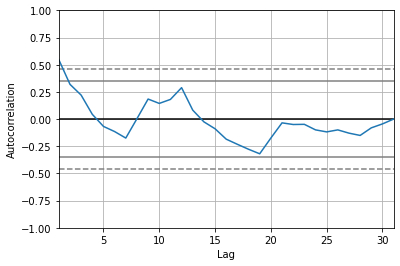

In [28]:
autocorrelation_plot(ts_train.item_cnt_day)

In [41]:
!pip install statsmodels

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


                             ARIMA Model Results                              
Dep. Variable:         D.item_cnt_day   No. Observations:                   30
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -341.066
Method:                       css-mle   S.D. of innovations          20067.070
Date:                Mon, 21 Jun 2021   AIC                            690.132
Time:                        18:05:06   BIC                            695.737
Sample:                             1   HQIC                           691.925
                                                                              
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -1862.3718    649.406     -2.868      0.008   -3135.184    -589.559
ar.L1.D.item_cnt_day     0.4192      0.175      2.398      0.024       0.077       0.762
ma.L1.D.item

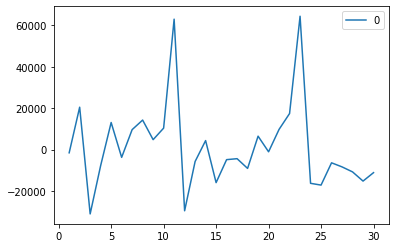

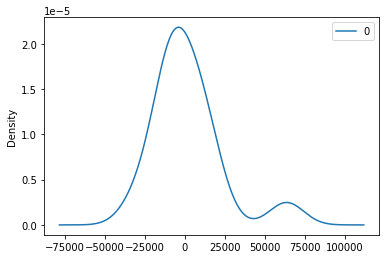

                  0
count     30.000000
mean    1290.181597
std    21152.232424
min   -30993.158932
25%   -10309.707153
50%    -4039.336399
75%     9746.748193
max    64331.082255


In [45]:
# fit an ARIMA model and plot residual errors
from pandas import datetime
from pandas import read_csv
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot

# fit model
model = ARIMA(ts_train.item_cnt_day, order=(1,1,1))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

In [47]:
import statsmodels.api as sm
mod=sm.tsa.statespace.SARIMAX(ts_train.item_cnt_day, order=(1,1,1), seasonal_order=(1, 1, 1, 12))


In [53]:
import itertools

In [55]:
p = range(0, 3)
d = range(1,2)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts_train.item_cnt_day,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 1, 1) x (0, 1, 1, 12)
SARIMAX: (0, 1, 1) x (0, 1, 2, 12)
SARIMAX: (0, 1, 2) x (1, 1, 0, 12)
SARIMAX: (0, 1, 2) x (1, 1, 1, 12)
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:368.35092547044053
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:128.89745579648866
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:342.59783154729837
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:128.93954043177007
ARIMA(0, 1, 2)x(0, 1, 0, 12)12 - AIC:324.4643314563821
ARIMA(0, 1, 2)x(1, 1, 0, 12)12 - AIC:128.0267951098865
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:368.97366049550294
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:109.03764584645204
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:344.50481304022566
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:110.2943889349969
ARIMA(1, 1, 2)x(0, 1, 0, 12)12 - AIC:324.3828685989396
ARIMA(1, 1, 2)x(1, 1, 0, 12)12 - AIC:108.9818725758072
ARIMA(2, 1, 0)x(0, 1, 0, 12)12 - AIC:341.88187118696203
ARIMA(2, 1, 0)x(1, 1, 0, 12)12 - AIC:82.01582680841457
ARIMA(2, 1, 1)x(0, 1, 0, 

In [61]:
# define model
s_model = sm.tsa.statespace.SARIMAX(ts_train.item_cnt_day, order=(2,1,0), seasonal_order=(1,1,0,12))
# fit model
s_model_fit = s_model.fit()
print(s_model_fit.summary())

                                 Statespace Model Results                                 
Dep. Variable:                       item_cnt_day   No. Observations:                   31
Model:             SARIMAX(2, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -193.383
Date:                            Mon, 21 Jun 2021   AIC                            394.766
Time:                                    18:24:36   BIC                            398.328
Sample:                                         0   HQIC                           395.257
                                             - 31                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0211      0.152      0.139      0.890      -0.277       0.319
ar.L2          0.0326      0.061   

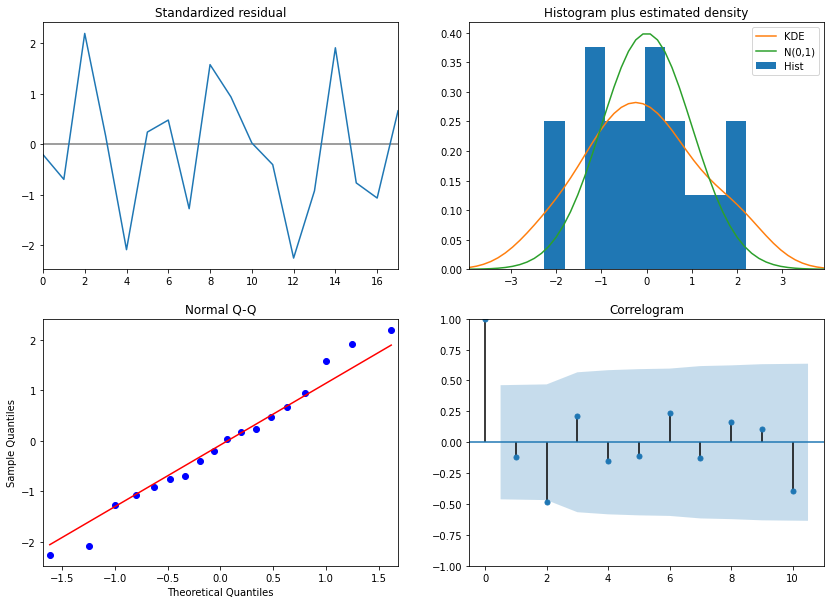

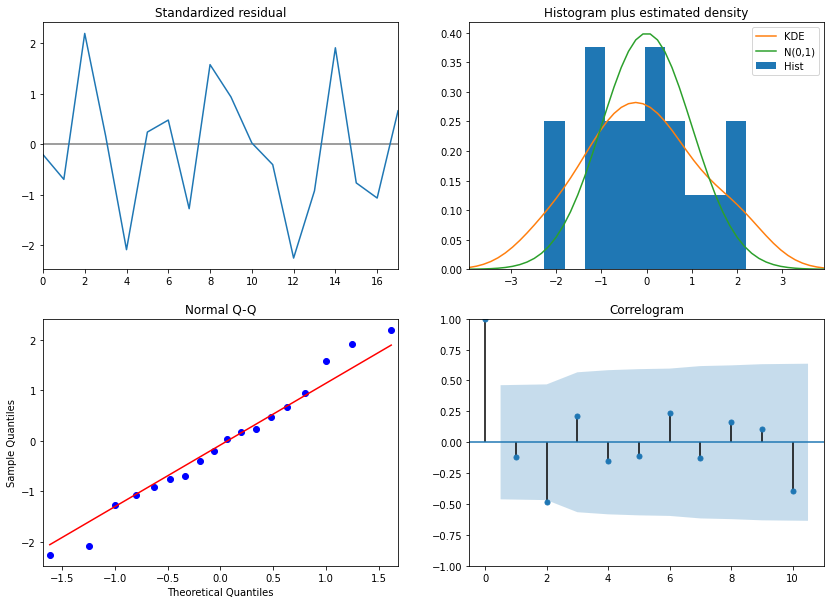

In [68]:
s_model_fit.plot_diagnostics(figsize=(14,10))

In [70]:
forecast_value=s_model_fit.get_forecast(steps=3)
forecast_value.summary_frame()

item_cnt_day,mean,mean_se,mean_ci_lower,mean_ci_upper
31,74256.341101,8754.909990,57097.032833,91415.649369
32,71625.628954,12512.597758,47101.387994,96149.869913
33,78975.475582,15548.165039,48501.632080,109449.319083


In [72]:
forecast_value.predicted_mean

31    74256.341101
32    71625.628954
33    78975.475582
dtype: float64

In [86]:
forecast_ci=forecast_value.conf_int()
forecast_ci

,lower item_cnt_day,upper item_cnt_day
31,57097.032833,91415.649369
32,47101.387994,96149.869913
33,48501.632080,109449.319083


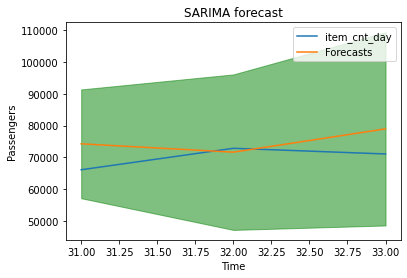

In [88]:
#PLot the data
ax = ts_test['item_cnt_day'].plot()
#PLot the forecasted values
forecast_value.predicted_mean.plot(ax=ax, label='Forecasts')
#PLot the Confidence Intervals
ax.fill_between(forecast_ci.index,
                forecast_ci.iloc[: , 0],
                forecast_ci.iloc[:, 1], color='g', alpha=.5)
# Axes Labels and Title
ax. set_xlabel('Time')
ax. set_ylabel('Passengers')
ax. set_title('SARIMA forecast')
#Legneds
plt. legend()

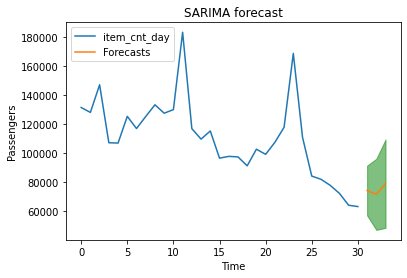

In [89]:
#PLot the data
ax = ts_train['item_cnt_day'].plot()
#PLot the forecasted values
forecast_value.predicted_mean.plot(ax=ax, label='Forecasts')
#PLot the Confidence Intervals
ax.fill_between(forecast_ci.index,
                forecast_ci.iloc[: , 0],
                forecast_ci.iloc[:, 1], color='g', alpha=.5)
# Axes Labels and Title
ax. set_xlabel('Time')
ax. set_ylabel('Passengers')
ax. set_title('SARIMA forecast')
#Legneds
plt. legend()

In [106]:
import sklearn.metrics
import math
actual=ts_test['item_cnt_day']
prediction= forecast_value.predicted_mean
mse = sklearn.metrics.mean_squared_error(actual, prediction)
rmse = math.sqrt(mse)
#Defining MAPE function
def MAPE(y_actual,y_prediction):
    mape = np.mean(np.abs((y_actual - y_prediction)/y_actual))*100
    return mape

print('MSE:', mse, ' ', 'RMSE:',rmse, ' ', 'MAPE:',MAPE(actual,prediction))

MSE: 43689664.40996017   RMSE: 6609.815762179773   MAPE: 8.397241404430652
